In [552]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
import yfinance as yf
import sys

print("Num GPUs Available: ",len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [605]:
# Parameters
STOCKS = ['AAPL', 'GOOGL', 'META', 'AMZN', 'NFLX','XOM']  # List of stock symbols to train on
PREDICTION_DAYS = 60  # Number of days of historical data to use as input
PREDICTION_DAYS_AHEAD = 5  # Number of days to predict in advance
EPOCHS = 80  # Number of training epochs
BATCH_SIZE = 32  # Batch size for training
TRAIN_SPLIT = 0.8  # Split ratio for training data
STOCK_FOR_VALIDATION = 'AAPL'  # Stock to use for validation plot
MOVING_AVERAGE = 30 #Minimum value of 1
LSTM_UNITS = 150 * len(STOCKS) #How big brain the model is

START_DATE = "2014-01-01"
END_DATE = "2019-01-30"

In [554]:
# Function to load stock data from Yahoo Finance
def load_data(stock_symbol):
    data = yf.download(stock_symbol, start=START_DATE, end=END_DATE)
    #print(data)
    return data['Close'].values  # Use closing price

# Function to normalize data using min-max scaling with numpy
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

# Function to denormalize data
def denormalize_data(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Calculate moving average (no change in array length)
def moving_average(data, window=MOVING_AVERAGE):
    averaged_data = []
    moving_total = 0
    denom = 0
    for i in range(len(data)):
        moving_total += data[i]
        denom += 1
        if(i > window):
            moving_total -= data[i-window]
            denom -= 1
        averaged_data.append(moving_total/denom)
    return averaged_data

# Function to preprocess data with moving average and variable prediction days
def preprocess_data(stock_data, stock_id):
    if(PREDICTION_DAYS > len(stock_data)):
        print("Error: PREDICTION_DAYS set to",PREDICTION_DAYS,"but stock_data is only",len(stock_data),"elements long")
        sys.exit(1)
    
    normalized_data, min_val, max_val = normalize_data(stock_data)
    
    x_train, y_train = [], []

    #removes first portion of data. Cannot predict when we don't have at least PREDICTION_DAYS + PREDICTION_DAYS_AHEAD of history.
    for i in range(PREDICTION_DAYS + PREDICTION_DAYS_AHEAD - 1, len(normalized_data)):
        x_train.append(normalized_data[i+1-(PREDICTION_DAYS + PREDICTION_DAYS_AHEAD):(i+1-PREDICTION_DAYS_AHEAD)]) #append an array of past values which will be input for LSTM model
        y_train.append(normalized_data[i]) #append the "answer" for correct y value
    
    return np.array(x_train), np.array(y_train), min_val, max_val

# Function to build the LSTM model with variable output days and 4 features in input
def build_model():
    model = Sequential()
    model.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(PREDICTION_DAYS, len(STOCKS)))) 
    model.add(Dropout(0.2))
    model.add(LSTM(units=LSTM_UNITS, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer now predicts multiple days
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Metric to monitor
    patience=10,          # Number of epochs with no improvement before stopping
    verbose=1,            # Display stopping message
    restore_best_weights=True  # Restore weights from the best epoch
)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\rayta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - loss: 0.0913 - val_loss: 0.0168
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - loss: 5.4921e-04 - val_loss: 0.0059
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - loss: 5.2721e-04 - val_loss: 0.0053
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - loss: 5.2959e-04 - val_loss: 0.0035
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - loss: 4.0871e-04 - val_loss: 0.0020
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - loss: 4.9441e-04 - val_loss: 0.0034
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - loss: 3.2414e-04 - val_loss: 0.0018
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - loss: 3.9307e-04 - val_loss: 0.0031
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - loss: 3.6853e-04 - val_loss: 0.0079
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - loss: 4.6752e-04 - val_loss: 0.0020
Epoch

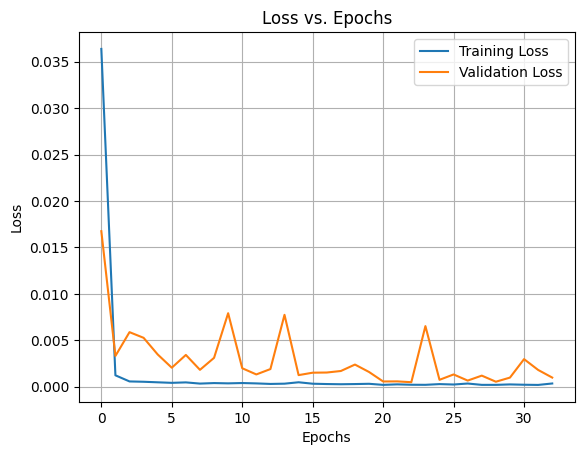

In [555]:
# Main execution: preprocess data for each stock and concatenate
all_x_data = []
selected_stock_x_data, selected_stock_y_data, = [], []
selected_stock_min, selected_stock_max = 0, 0
for stock_id, stock in enumerate(STOCKS):
    stock_data = load_data(stock)
    # Apply moving average to smooth data
    stock_data_smoothed = moving_average(stock_data)
    x_train, y_train, min_val, max_val = preprocess_data(stock_data_smoothed, stock_id)
    if(stock == STOCK_FOR_VALIDATION):
        selected_stock_min, selected_stock_max = min_val, max_val
        selected_stock_x_data = x_train
        selected_stock_y_data = y_train
    all_x_data.append(x_train)
    
# Combine training data from all stocks
processed_x_data = np.concatenate(all_x_data, axis=2)
processed_y_data = np.concatenate(selected_stock_y_data)
processed_sel_x_data = np.concatenate(selected_stock_x_data)

# Split data into training and validation sets
split_index = int(TRAIN_SPLIT * len(processed_x_data))
all_x_train_data = processed_x_data[:split_index]
all_x_validation_data = processed_x_data[split_index:]
y_train_data = processed_y_data[:split_index]
y_validation_data = processed_y_data[split_index:]

# Build and train the model
model = build_model()
history = model.fit(all_x_train_data, y_train_data, validation_data=(all_x_validation_data, y_validation_data), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Make predictions on the training data
train_predictions = model.predict(all_x_train_data)
train_predicted_prices = denormalize_data(train_predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale
train_real_prices = denormalize_data(y_train_data, selected_stock_min, selected_stock_max)

# Make predictions on the validation data
predictions = model.predict(all_x_validation_data)
predicted_prices = denormalize_data(predictions, selected_stock_min, selected_stock_max)  # Convert predictions to original scale
real_prices = denormalize_data(y_validation_data, selected_stock_min, selected_stock_max)

# Plot loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


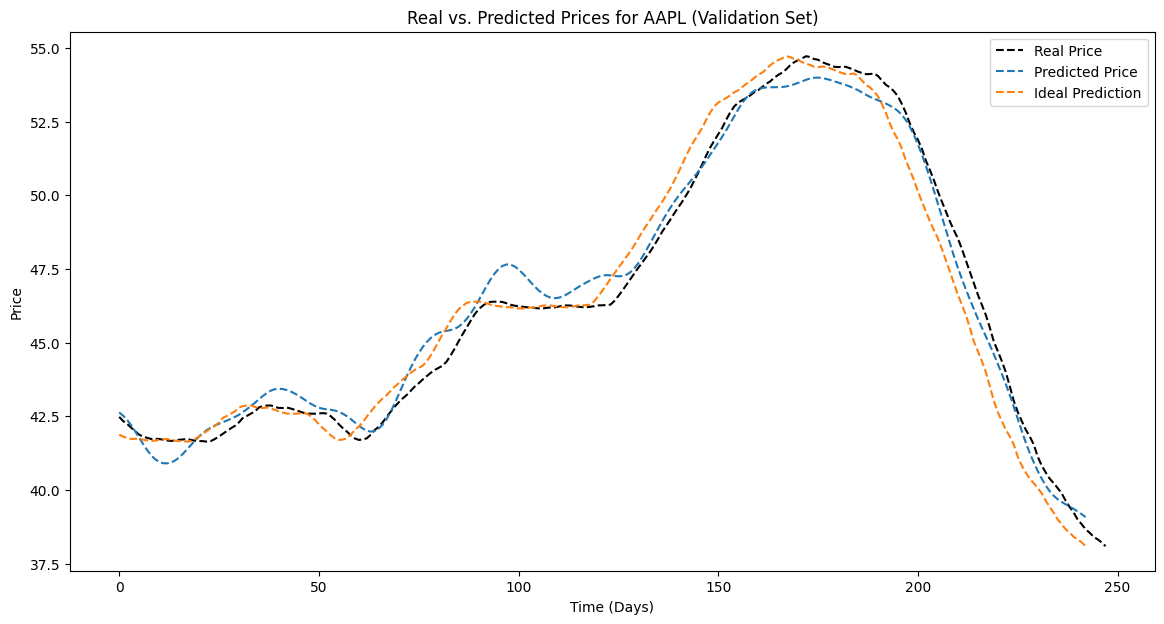

In [556]:
# Load real closing prices for the validation period
real_prices_data = yf.download(STOCK_FOR_VALIDATION, start=START_DATE, end=END_DATE)['Close'].values
real_prices_data = moving_average(real_prices_data)
real_prices_data = real_prices_data[PREDICTION_DAYS-1:]

real_prices_data_validation = real_prices_data[split_index:]  # Use only the validation portion
real_prices_data_training = real_prices_data[:split_index]  # Plot for training portion
# Plot the results for the validation portion
plt.figure(figsize=(14, 7))

# Plot the real prices directly
plt.plot(real_prices_data_validation, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(predicted_prices, label='Predicted Price ', linestyle='--')
plt.plot(real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"Real vs. Predicted Prices for {STOCK_FOR_VALIDATION} (Validation Set)")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.show()

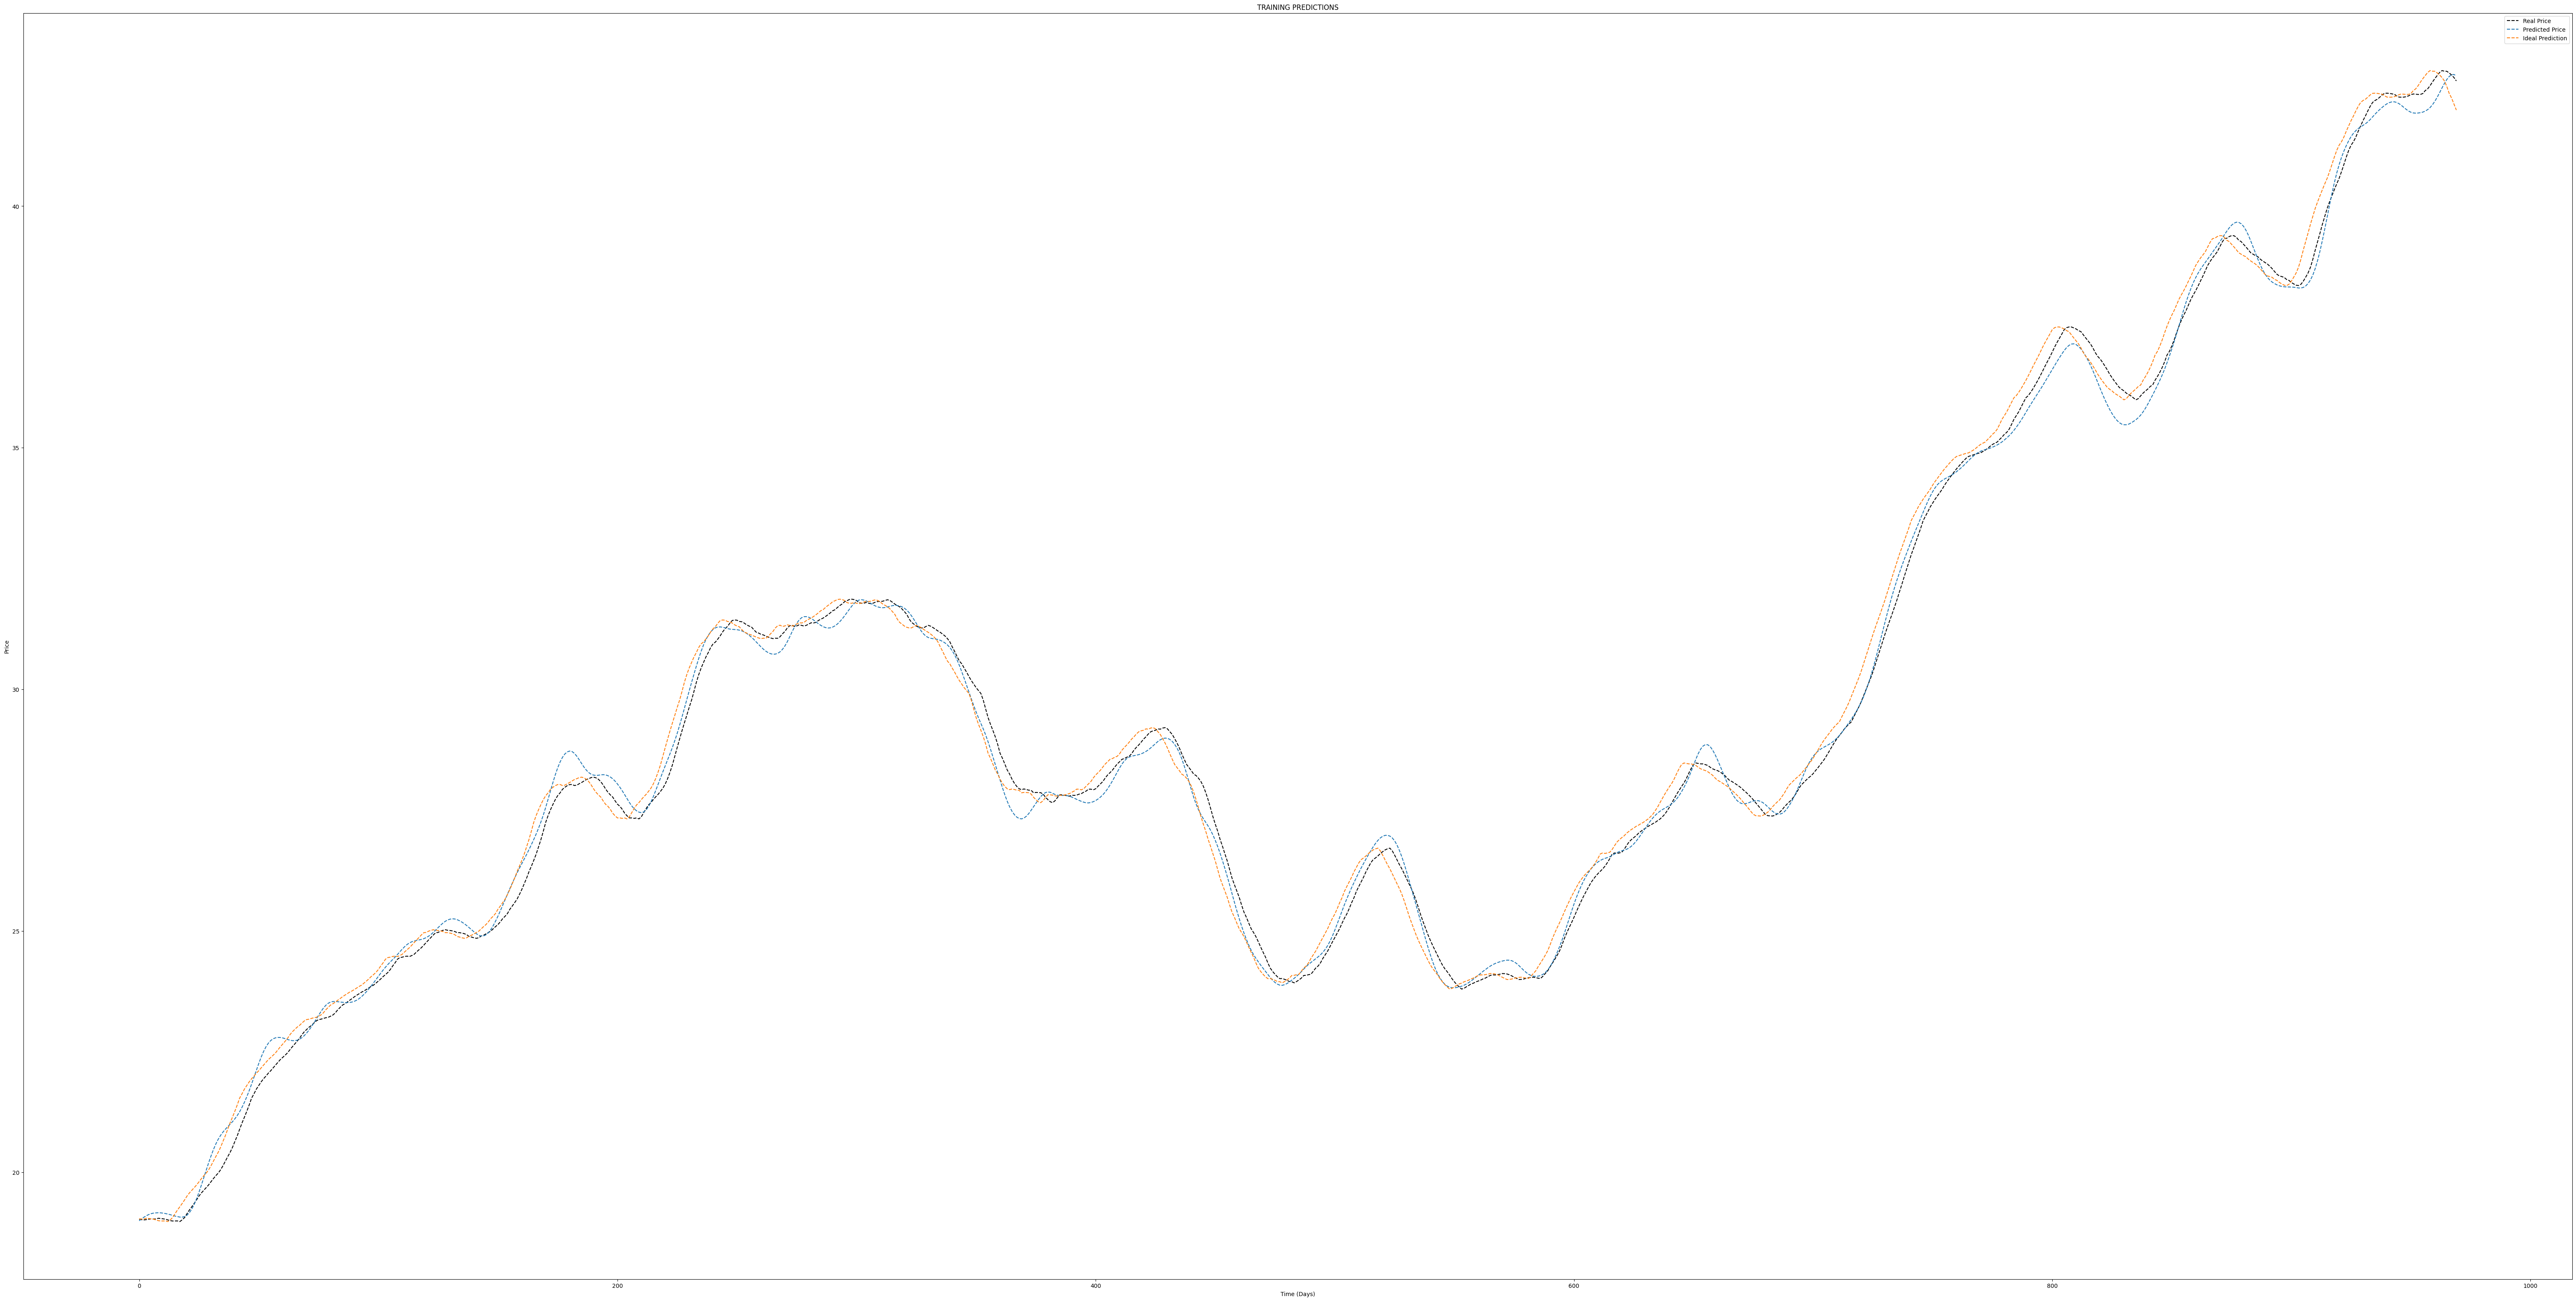

In [ ]:
# Plot the results for the validation portion
plt.figure(figsize=(80, 40))

# Plot the real prices directly
plt.plot(real_prices_data_training, label='Real Price', color='black', linestyle='--')

# Plot predicted prices for each prediction day in the range of PREDICTION_DAYS_AHEAD

plt.plot(train_predicted_prices, label='Predicted Price', linestyle='--')
plt.plot(train_real_prices, label='Ideal Prediction',linestyle='--')

plt.title(f"TRAINING PREDICTIONS")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
#plt.xlim(2200, 2250)
plt.show()

In [607]:
# Stack historical data for all stocks
all_stock_data = []
for stock in STOCKS:
    stock_data = load_data(stock)
    all_stock_data = np.append(all_stock_data,stock_data,axis=1) if len(all_stock_data) else stock_data

# Assuming `all_stock_data` is a 2D NumPy array of shape (time_steps, num_stocks)
# and `STOCKS` is the list of stock symbols
chosen_stock_index = STOCKS.index(STOCK_FOR_VALIDATION)  # Find the index of the chosen stock

# Calculate the correlation coefficients
correlation_values = np.corrcoef(all_stock_data, rowvar=False)[chosen_stock_index]

# Output the correlation values with each stock
print(f"Correlation of {STOCK_FOR_VALIDATION} with other stocks:")
for i, stock in enumerate(STOCKS):
    print(f"  {STOCK_FOR_VALIDATION} and {stock}: {correlation_values[i]:.2f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Correlation of AAPL with other stocks:
  AAPL and AAPL: 1.00
  AAPL and GOOGL: 0.87
  AAPL and META: 0.83
  AAPL and AMZN: 0.90
  AAPL and NFLX: 0.90
  AAPL and XOM: -0.57
